<a href="https://colab.research.google.com/github/wasiq0/Bitcoin-Prediction/blob/main/503.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kundanbedmutha/exam-score-prediction-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'exam-score-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/exam-score-prediction-dataset


In [ ]:
import os

for file in os.listdir(path):
    print(file)


Exam_Score_Prediction.csv


In [ ]:
import csv

csv_path = path + "/Exam_Score_Prediction.csv"

rows = []
with open(csv_path, "r") as f:
    reader = csv.DictReader(f)
    for r in reader:
        rows.append(r)

len(rows), rows[:3]


(20000,
 [{'student_id': '1',
   'age': '17',
   'gender': 'male',
   'course': 'diploma',
   'study_hours': '2.78',
   'class_attendance': '92.9',
   'internet_access': 'yes',
   'sleep_hours': '7.4',
   'sleep_quality': 'poor',
   'study_method': 'coaching',
   'facility_rating': 'low',
   'exam_difficulty': 'hard',
   'exam_score': '58.9'},
  {'student_id': '2',
   'age': '23',
   'gender': 'other',
   'course': 'bca',
   'study_hours': '3.37',
   'class_attendance': '64.8',
   'internet_access': 'yes',
   'sleep_hours': '4.6',
   'sleep_quality': 'average',
   'study_method': 'online videos',
   'facility_rating': 'medium',
   'exam_difficulty': 'moderate',
   'exam_score': '54.8'},
  {'student_id': '3',
   'age': '22',
   'gender': 'male',
   'course': 'b.sc',
   'study_hours': '7.88',
   'class_attendance': '76.8',
   'internet_access': 'yes',
   'sleep_hours': '8.5',
   'sleep_quality': 'poor',
   'study_method': 'coaching',
   'facility_rating': 'high',
   'exam_difficulty': 'm

In [ ]:
# Cell 1 - locate dataset CSV automatically
import os, glob, pprint

candidates = []

# current working dir
candidates += glob.glob("/content/*.csv")
# search recursively in common kagglehub cache
candidates += glob.glob(os.path.expanduser("~/.cache/kagglehub/datasets/**/*.*"), recursive=True)
# search any 'exam' or 'score' named csv anywhere under /root or /content
candidates += glob.glob("/root/**/*.csv", recursive=True)
candidates += glob.glob("/content/**/exam*.csv", recursive=True)
candidates += glob.glob("/content/**/score*.csv", recursive=True)

# filter only csv files and unique
candidates = [p for p in candidates if p.lower().endswith(".csv")]
candidates = sorted(set(candidates))

print("Found CSV candidates (first 20):")
pprint.pprint(candidates[:20])

if len(candidates)==0:
    print("\nNo CSV found automatically. If you ran kagglehub, run the kagglehub download cell next.")
else:
    # choose best guess: prefer files with 'exam' or 'score' in name
    preferred = [p for p in candidates if ('exam' in os.path.basename(p).lower() or 'score' in os.path.basename(p).lower())]
    default = preferred[0] if preferred else candidates[0]
    print("\nUsing:", default)
    DATA_CSV = default


Found CSV candidates (first 20):
[]

No CSV found automatically. If you ran kagglehub, run the kagglehub download cell next.


In [ ]:
# Cell 2 - download dataset via kagglehub if not found
try:
    DATA_CSV
    print("Dataset already found:", DATA_CSV)
except NameError:
    print("No dataset found yet. Attempting to download via kagglehub (kundanbedmutha/exam-score-prediction-dataset).")
    import kagglehub, os
    path = kagglehub.dataset_download("kundanbedmutha/exam-score-prediction-dataset")
    print("kagglehub path:", path)
    # look for csv in that folder
    import glob
    files = glob.glob(os.path.join(path, "*.csv"))
    if len(files)==0:
        files = glob.glob(os.path.join(path, "**/*.csv"), recursive=True)
    if len(files)==0:
        raise FileNotFoundError("No CSV found in kagglehub download path: "+path)
    DATA_CSV = files[0]
    print("Using:", DATA_CSV)


No dataset found yet. Attempting to download via kagglehub (kundanbedmutha/exam-score-prediction-dataset).
Using Colab cache for faster access to the 'exam-score-prediction-dataset' dataset.
kagglehub path: /kaggle/input/exam-score-prediction-dataset
Using: /kaggle/input/exam-score-prediction-dataset/Exam_Score_Prediction.csv


In [ ]:
# Cell 3 - quick peek using csv module
import csv
print("Previewing first 5 rows of:", DATA_CSV)
with open(DATA_CSV, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    rows = []
    for i, r in enumerate(reader):
        rows.append(r)
        if i >= 4:
            break
for i,r in enumerate(rows):
    print(f"Row {i+1}:")
    print({k: r[k] for k in r})


Previewing first 5 rows of: /kaggle/input/exam-score-prediction-dataset/Exam_Score_Prediction.csv
Row 1:
{'student_id': '1', 'age': '17', 'gender': 'male', 'course': 'diploma', 'study_hours': '2.78', 'class_attendance': '92.9', 'internet_access': 'yes', 'sleep_hours': '7.4', 'sleep_quality': 'poor', 'study_method': 'coaching', 'facility_rating': 'low', 'exam_difficulty': 'hard', 'exam_score': '58.9'}
Row 2:
{'student_id': '2', 'age': '23', 'gender': 'other', 'course': 'bca', 'study_hours': '3.37', 'class_attendance': '64.8', 'internet_access': 'yes', 'sleep_hours': '4.6', 'sleep_quality': 'average', 'study_method': 'online videos', 'facility_rating': 'medium', 'exam_difficulty': 'moderate', 'exam_score': '54.8'}
Row 3:
{'student_id': '3', 'age': '22', 'gender': 'male', 'course': 'b.sc', 'study_hours': '7.88', 'class_attendance': '76.8', 'internet_access': 'yes', 'sleep_hours': '8.5', 'sleep_quality': 'poor', 'study_method': 'coaching', 'facility_rating': 'high', 'exam_difficulty': 'mod

In [ ]:
# Cell 4 - create normalized SQLite DB and insert rows (ETL)
import sqlite3, os, csv

DB_PATH = "/content/student_performance.db"
if os.path.exists(DB_PATH):
    print("Overwriting existing DB at", DB_PATH)
    os.remove(DB_PATH)

conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()

# Create schema - matches your dataset columns (plus facility_rating, exam_difficulty)
cur.executescript("""
PRAGMA foreign_keys = ON;
CREATE TABLE courses (course_id INTEGER PRIMARY KEY AUTOINCREMENT, course_name TEXT UNIQUE);
CREATE TABLE students (
    student_id TEXT PRIMARY KEY,
    age INTEGER,
    gender TEXT,
    course_id INTEGER,
    FOREIGN KEY(course_id) REFERENCES courses(course_id)
);
CREATE TABLE study_habits (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    student_id TEXT,
    study_hours REAL,
    class_attendance REAL,
    study_method TEXT,
    FOREIGN KEY(student_id) REFERENCES students(student_id)
);
CREATE TABLE lifestyle (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    student_id TEXT,
    sleep_hours REAL,
    sleep_quality TEXT,
    internet_access TEXT,
    facility_rating TEXT,
    FOREIGN KEY(student_id) REFERENCES students(student_id)
);
CREATE TABLE exams (
    exam_id INTEGER PRIMARY KEY AUTOINCREMENT,
    student_id TEXT,
    exam_difficulty TEXT,
    final_exam_score REAL,
    FOREIGN KEY(student_id) REFERENCES students(student_id)
);
""")
conn.commit()

# Insert rows by reading CSV
def upsert_course(conn, course_name):
    cur = conn.cursor()
    if course_name is None or str(course_name).strip()=="":
        return None
    cur.execute("SELECT course_id FROM courses WHERE course_name = ?", (course_name,))
    row = cur.fetchone()
    if row:
        return row[0]
    cur.execute("INSERT INTO courses (course_name) VALUES (?)", (course_name,))
    conn.commit()
    return cur.lastrowid

with open(DATA_CSV, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    count=0
    for r in reader:
        sid = r.get("student_id") or r.get("id") or str(count+1)
        course_name = r.get("course")
        course_id = upsert_course(conn, course_name)
        # students
        age = r.get("age")
        age = int(age) if age and age.strip()!='' else None
        cur.execute("INSERT OR REPLACE INTO students (student_id, age, gender, course_id) VALUES (?, ?, ?, ?)",
                    (sid, age, r.get("gender"), course_id))
        # study_habits
        def to_float(x):
            try:
                return float(x)
            except:
                return None
        cur.execute("INSERT INTO study_habits (student_id, study_hours, class_attendance, study_method) VALUES (?, ?, ?, ?)",
                    (sid, to_float(r.get("study_hours") or r.get("hours_studied")), to_float(r.get("class_attendance") or r.get("attendance")), r.get("study_method")))
        # lifestyle
        cur.execute("INSERT INTO lifestyle (student_id, sleep_hours, sleep_quality, internet_access, facility_rating) VALUES (?, ?, ?, ?, ?)",
                    (sid, to_float(r.get("sleep_hours")), r.get("sleep_quality"), r.get("internet_access"), r.get("facility_rating")))
        # exams
        cur.execute("INSERT INTO exams (student_id, exam_difficulty, final_exam_score) VALUES (?, ?, ?)",
                    (sid, r.get("exam_difficulty"), to_float(r.get("exam_score") or r.get("final_exam_score") or r.get("exam_score"))))
        count+=1
        if count % 5000 == 0:
            print("Inserted", count, "rows...")
conn.commit()
print("Inserted total rows:", count)
conn.close()
print("DB created at:", DB_PATH)


Inserted 5000 rows...
Inserted 10000 rows...
Inserted 15000 rows...
Inserted 20000 rows...
Inserted total rows: 20000
DB created at: /content/student_performance.db


In [ ]:
# Cell 5 - load flattened table into pandas for EDA & modeling
import pandas as pd, sqlite3
conn = sqlite3.connect(DB_PATH)
QUERY = """
SELECT s.student_id, s.age, s.gender, c.course_name as course,
       sh.study_hours, sh.class_attendance, sh.study_method,
       l.sleep_hours, l.sleep_quality, l.internet_access, l.facility_rating,
       e.exam_difficulty, e.final_exam_score as exam_score
FROM students s
LEFT JOIN courses c ON s.course_id = c.course_id
LEFT JOIN study_habits sh ON s.student_id = sh.student_id
LEFT JOIN lifestyle l ON s.student_id = l.student_id
LEFT JOIN exams e ON s.student_id = e.student_id
"""
df = pd.read_sql_query(QUERY, conn)
conn.close()
print("Loaded dataframe:", df.shape)
df.head()


Loaded dataframe: (20000, 13)


,student_id,age,gender,course,study_hours,class_attendance,study_method,sleep_hours,sleep_quality,internet_access,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,coaching,7.4,poor,yes,low,hard,58.9
1,2,23,other,bca,3.37,64.8,online videos,4.6,average,yes,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,coaching,8.5,poor,yes,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,online videos,5.8,average,yes,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,coaching,9.8,poor,yes,low,moderate,43.7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   student_id        20000 non-null  object 
 1   age               20000 non-null  int64  
 2   gender            20000 non-null  object 
 3   course            20000 non-null  object 
 4   study_hours       20000 non-null  float64
 5   class_attendance  20000 non-null  float64
 6   study_method      20000 non-null  object 
 7   sleep_hours       20000 non-null  float64
 8   sleep_quality     20000 non-null  object 
 9   internet_access   20000 non-null  object 
 10  facility_rating   20000 non-null  object 
 11  exam_difficulty   20000 non-null  object 
 12  exam_score        20000 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 2.0+ MB
None
                    count unique         top   freq       mean        std  \
student_id          20000  20000       199

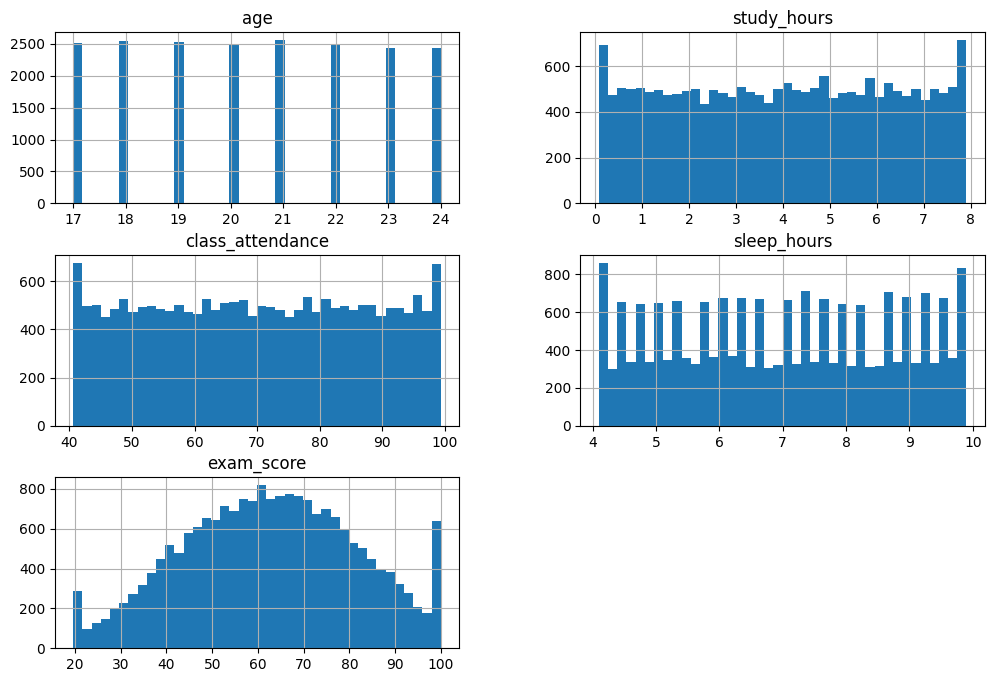

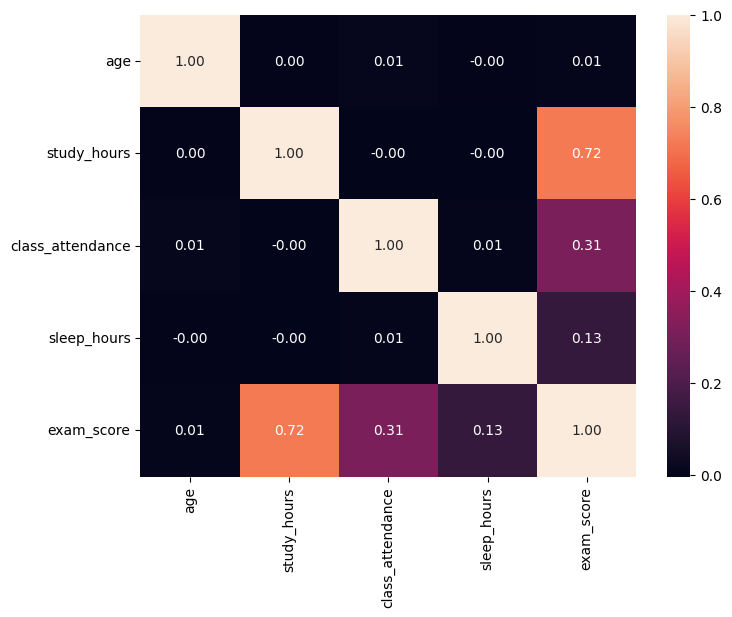

In [ ]:
# Cell 6 - quick EDA
import matplotlib.pyplot as plt, seaborn as sns
print(df.info())
print(df.describe(include='all').T)

# Value counts for categorical columns
for c in ["gender","course","internet_access","sleep_quality","study_method","facility_rating","exam_difficulty"]:
    if c in df.columns:
        print("\n", c, df[c].value_counts(dropna=False).head(10))

# histograms for numeric cols
num_cols = df.select_dtypes(include=['number']).columns.tolist()
df[num_cols].hist(bins=40, figsize=(12,8))
plt.show()

# correlation heatmap for numeric columns
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f")
plt.show()


In [ ]:
# Cell 7 - missing values & outliers detection
print("Missing per column:\n", df.isna().sum())

def detect_outliers_iqr(s):
    s = s.dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return s[(s < lower) | (s > upper)]

for c in num_cols:
    out = detect_outliers_iqr(df[c])
    print(f"{c}: {len(out)} outliers (IQR)")


Missing per column:
 student_id          0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
study_method        0
sleep_hours         0
sleep_quality       0
internet_access     0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64
age: 0 outliers (IQR)
study_hours: 0 outliers (IQR)
class_attendance: 0 outliers (IQR)
sleep_hours: 0 outliers (IQR)
exam_score: 0 outliers (IQR)


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# numerical & categorical columns
num_cols = ['age', 'study_hours', 'class_attendance', 'sleep_hours']
cat_cols = ['gender', 'course', 'study_method', 'sleep_quality', 'internet_access', 'facility_rating', 'exam_difficulty']

# numeric pipeline
num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

# categorical pipeline
cat_pipeline = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# column transformer
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# full model pipeline
model = Pipeline([
    ("preprocess", preprocessor),
    ("rf", RandomForestRegressor())
])

# split data
X = df.drop("exam_score", axis=1)
y = df["exam_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'study_hours',
                                                   'class_attendance',
                                                   'sleep_hours']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'course',
                                                   'study_method',
                                                   'sleep_quality',
                                                   'internet_access',
                                                   'facility_rating',
                                                   'exam_difficulty'])])),
                ('rf', RandomForestRegressor())])

In [ ]:
# Cell 9 - save model and link for download
import joblib
MODEL_PATH = "/content/student_exam_score_model.pkl"
joblib.dump(model, MODEL_PATH)
print("Saved model to:", MODEL_PATH)

# provide a download link in Colab
from google.colab import files
files.download(MODEL_PATH)


Saved model to: /content/student_exam_score_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.9 MB/s eta 0:00:00


In [ ]:
import os
os.makedirs("/content/model", exist_ok=True)

shutil.copy("/content/student_exam_score_model.pkl", "/content/model/student_exam_score_model.pkl")


'/content/model/student_exam_score_model.pkl'

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mlflow.models import infer_signature
import mlflow
import mlflow.sklearn
import numpy as np

experiment_name = "student_exam_score_experiment_colab"
mlflow.set_experiment(experiment_name)

with mlflow.start_run():

    # Train model
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    # Log params
    mlflow.log_param("model", "RandomForest")
    mlflow.log_param("n_estimators", model["rf"].n_estimators)

    # Log metrics
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("R2", r2)

    # Signature + Example
    input_example = X_train.iloc[:1]
    signature = infer_signature(X_train, model.predict(X_train))

    # Log model (updated)
    mlflow.sklearn.log_model(
        model,
        name="model",
        input_example=input_example,
        signature=signature
    )
print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)


/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


RMSE: 10.315450497415295
MAE: 8.319681655
R2: 0.7025177352249854


In [ ]:
# Generate Dockerfile, app.py, and streamlit_app.py

dockerfile_content = """
FROM python:3.10

WORKDIR /app

COPY app.py /app/app.py
COPY student_exam_score_model.pkl /app/student_exam_score_model.pkl

RUN pip install fastapi uvicorn scikit-learn pandas numpy

CMD ["uvicorn", "app:app", "--host", "0.0.0.0", "--port", "8000"]
"""

app_py_content = """
from fastapi import FastAPI
import joblib
import numpy as np

app = FastAPI()

model = joblib.load("student_exam_score_model.pkl")

@app.get("/")
def read_root():
    return {"message": "Exam Score Prediction API"}

@app.post("/predict")
def predict(data: dict):
    features = np.array([list(data.values())]).astype(float)
    prediction = model.predict(features)[0]
    return {"predicted_exam_score": float(prediction)}
"""

streamlit_app_content = """
import streamlit as st
import requests

st.title("Student Exam Score Predictor")

age = st.number_input("Age", 10, 60, 18)
study_hours = st.number_input("Study Hours", 0.0, 15.0, 2.0)
class_attendance = st.number_input("Class Attendance (%)", 0.0, 100.0, 75.0)
sleep_hours = st.number_input("Sleep Hours", 0.0, 12.0, 7.0)

if st.button("Predict"):
    data = {
        "age": age,
        "study_hours": study_hours,
        "class_attendance": class_attendance,
        "sleep_hours": sleep_hours
    }

    response = requests.post("http://YOUR-DROPLET-IP:8000/predict", json=data)
    st.write("Prediction:", response.json())
"""

# Write files
with open("/content/Dockerfile", "w") as f:
    f.write(dockerfile_content)

with open("/content/app.py", "w") as f:
    f.write(app_py_content)

with open("/content/streamlit_app.py", "w") as f:
    f.write(streamlit_app_content)

print("Created Dockerfile, app.py, and streamlit_app.py")


Created Dockerfile, app.py, and streamlit_app.py


In [ ]:
from google.colab import files
files.download('/content/Dockerfile')
files.download('/content/app.py')
files.download('/content/streamlit_app.py')
files.download('/content/student_exam_score_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>